In [248]:
from dotenv import load_dotenv
import warnings

warnings.filterwarnings("ignore")
load_dotenv('../.env')

True

In [249]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [250]:
pd.set_option('display.max_columns', None)

In [251]:
df = pd.read_csv('../data/trainingSet.csv')
display(df.shape)
df.head()

(311106, 40)

,index,eventType,period,periodTime,periodType,gameID,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,goalie,shotType,emptyNet,strength,season,rinkSide,gameType,totalPlayTime,lastEventType,lastEventPeriod,lastEventPeriodTime,lastEventXCoord,lastEventYCoord,Goal,EmptyNet,distanceFromNet,angle,gameSeconds,lastEventGameSeconds,timeFromLastEvent,distanceFromLastEvent,rebound,lastEventAngle,changeInAngleShot,speed,timeSincePowerPlayStarted,numFriendlyNonGoalieSkaters,numOpposingNonGoalieSkaters,strength2
0,0,Shot,1,00:51,REGULAR,2015020001,Toronto Maple Leafs,home,-55.0,6.0,Brad Boyes,Carey Price,Wrist Shot,NaN,NaN,2015,right,R,01:00:00,Hit,1,00:40,94.0,-34.0,0.0,0.0,34.525353,79.992020,51.0,40.0,11.0,154.275727,0.0,NaN,NaN,14.025066,0.0,5.0,5.0,Even
1,1,Shot,1,01:05,REGULAR,2015020001,Toronto Maple Leafs,home,-79.0,0.0,Nazem Kadri,Carey Price,Snap Shot,NaN,NaN,2015,right,R,01:00:00,Giveaway,1,00:58,-37.0,-28.0,0.0,0.0,10.000000,90.000000,65.0,58.0,7.0,50.477718,0.0,NaN,NaN,7.211103,0.0,5.0,5.0,Even
2,2,Shot,1,01:06,REGULAR,2015020001,Toronto Maple Leafs,home,-75.0,-1.0,Nazem Kadri,Carey Price,Snap Shot,NaN,NaN,2015,right,R,01:00:00,Shot,1,01:05,-79.0,0.0,0.0,0.0,14.035669,94.085617,66.0,65.0,1.0,4.123106,1.0,NaN,NaN,4.123106,0.0,5.0,5.0,Even
3,3,Shot,1,01:53,REGULAR,2015020001,Toronto Maple Leafs,home,-55.0,-36.0,Daniel Winnik,Carey Price,Wrist Shot,NaN,NaN,2015,right,R,01:00:00,Hit,1,01:35,-91.0,35.0,0.0,0.0,49.517674,136.636577,113.0,95.0,18.0,79.605276,0.0,NaN,NaN,4.422515,0.0,5.0,5.0,Even
4,4,Shot,1,02:37,REGULAR,2015020001,Toronto Maple Leafs,home,-61.0,-1.0,Joffrey Lupul,Carey Price,Tip-In,NaN,NaN,2015,right,R,01:00:00,Faceoff,1,02:32,-69.0,-22.0,0.0,0.0,28.017851,92.045408,157.0,152.0,5.0,22.472205,0.0,NaN,NaN,4.494441,0.0,5.0,5.0,Even


In [252]:
# Read and preprocess data
df = df[['distanceFromNet', 'angle', 'Goal']]
df = df.rename({'Goal': 'is_goal', 'distanceFromNet': 'distance'}, axis=1)
df = df.dropna().reset_index(drop=True)
df['is_goal'] = df['is_goal'].astype(np.int64)
display(df.shape)
df.head()

(311086, 3)

,distance,angle,is_goal
0,34.525353,79.992020,0
1,10.000000,90.000000,0
2,14.035669,94.085617,0
3,49.517674,136.636577,0
4,28.017851,92.045408,0


In [253]:
X = df[['distance', 'angle']]
y = df['is_goal'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

In [254]:
print(f'Dataset size: {len(X)}')
print(f'Training dataset size: {len(X_train)}')
print(f'Validation dataset size: {len(X_val)}')

Dataset size: 311086
Training dataset size: 248868
Validation dataset size: 62218


In [255]:
# goals rate
def goals_rate(df):
    nb_goals = len(df[df==1])
    nb_non_goals = len(df[df==0])
    goals_rate = nb_goals / (nb_goals+nb_non_goals)
    return goals_rate

gr1 = goals_rate(y)
gr2 = goals_rate(y_train)
gr3 = goals_rate(y_val)

print(f'** ALL ** Goals rate: {gr1} - Non-goals rate: {1-gr1}')
print(f'** Training ** Goals rate: {gr2} - Non-goals rate: {1-gr2}')
print(f'** Validation ** Goals rate: {gr3} - Non-goals rate: {1-gr3}')

** ALL ** Goals rate: 0.09378756999672117 - Non-goals rate: 0.9062124300032788
** Training ** Goals rate: 0.09368822026134337 - Non-goals rate: 0.9063117797386566
** Validation ** Goals rate: 0.09418496255103025 - Non-goals rate: 0.9058150374489697


In [256]:
### Logistic regression on distance ###

X_train1 = X_train['distance'].to_numpy().reshape(-1, 1)
X_val1 = X_val['distance'].to_numpy().reshape(-1, 1)

lr_clf1 = LogisticRegression().fit(X_train1, y_train)

train_score1 = lr_clf1.score(X_train1, y_train)
val_score1 = lr_clf1.score(X_val1, y_val)

print('***** Logistic regression (distance) *****')
print(f'Training accuracy: {train_score1}')
print(f'Test accuracy: {val_score1}')

***** Logistic regression (distance) *****
Training accuracy: 0.9063117797386566
Test accuracy: 0.9058150374489697


In [257]:
### Logistic regression on angle ###

X_train2 = X_train['angle'].to_numpy().reshape(-1, 1)
X_val2 = X_val['angle'].to_numpy().reshape(-1, 1)

lr_clf2 = LogisticRegression().fit(X_train2, y_train)

train_score2 = lr_clf2.score(X_train2, y_train)
val_score2 = lr_clf2.score(X_val2, y_val)

print('***** Logistic regression (angle) *****')
print(f'Training accuracy: {train_score2}')
print(f'Test accuracy: {val_score2}')

***** Logistic regression (angle) *****
Training accuracy: 0.9063117797386566
Test accuracy: 0.9058150374489697


In [258]:
### Logistic regression on distance + angle ###

X_train3 = X_train.to_numpy().reshape(-1, 2)
X_val3 = X_val.to_numpy().reshape(-1, 2)

lr_clf3 = LogisticRegression().fit(X_train3, y_train)

train_score3 = lr_clf3.score(X_train3, y_train)
val_score3 = lr_clf3.score(X_val3, y_val)

print('***** Logistic regression (distance+angle) *****')
print(f'Training accuracy: {train_score3}')
print(f'Test accuracy: {val_score3}')

***** Logistic regression (distance+angle) *****
Training accuracy: 0.9063117797386566
Test accuracy: 0.9058150374489697


In [259]:
### Random baseline ###
random_clf = DummyClassifier(strategy="uniform").fit(X_train3, y_train)

train_score4 = random_clf.score(X_train3, y_train)
val_score4 = random_clf.score(X_val3, y_val)

print('***** Random regression *****')
print(f'Training accuracy: {train_score4}')
print(f'Test accuracy: {val_score4}')

***** Random regression *****
Training accuracy: 0.4986900686307601
Test accuracy: 0.49927673663570027


Logistic Regression (trained on distance only): ROC AUC=0.685
Logistic Regression (trained on angle only): ROC AUC=0.507
Logistic Regression (trained on both distance and angle): ROC AUC=0.685
Random: ROC AUC=0.500


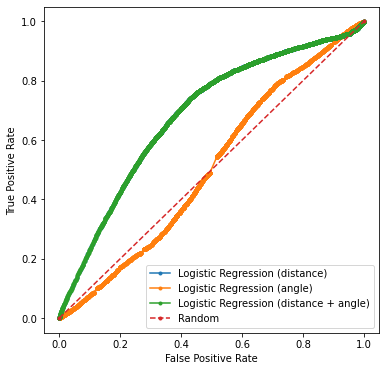

In [260]:
### ROC curve - AUC metric ###

lr_probs1 = lr_clf1.predict_proba(X_val1[:, :])[:,1]
lr_probs2 = lr_clf2.predict_proba(X_val2[:, :])[:,1]
lr_probs3 = lr_clf3.predict_proba(X_val3[:, :])[:,1]
random_probs = random_clf.predict_proba(X_val3[:, :])[:,1]


lr_auc1 = roc_auc_score(y_val, lr_probs1)
lr_auc2 = roc_auc_score(y_val, lr_probs2)
lr_auc3 = roc_auc_score(y_val, lr_probs3)
random_auc = roc_auc_score(y_val, random_probs)

print('Logistic Regression (trained on distance only): ROC AUC=%.3f' % (lr_auc1))
print('Logistic Regression (trained on angle only): ROC AUC=%.3f' % (lr_auc2))
print('Logistic Regression (trained on both distance and angle): ROC AUC=%.3f' % (lr_auc3))
print('Random: ROC AUC=%.3f' % (random_auc))

lr_fpr1, lr_tpr1, _ = roc_curve(y_val, lr_probs1)
lr_fpr2, lr_tpr2, _ = roc_curve(y_val, lr_probs2)
lr_fpr3, lr_tpr3, _ = roc_curve(y_val, lr_probs3)
random_fpr, random_tpr, _ = roc_curve(y_val, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(lr_fpr1, lr_tpr1, marker='.', label='Logistic Regression (distance)')
plt.plot(lr_fpr2, lr_tpr2, marker='.', label='Logistic Regression (angle)')
plt.plot(lr_fpr3, lr_tpr3, marker='.', label='Logistic Regression (distance + angle)')
plt.plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('../figures/3-roc.png')

plt.show()

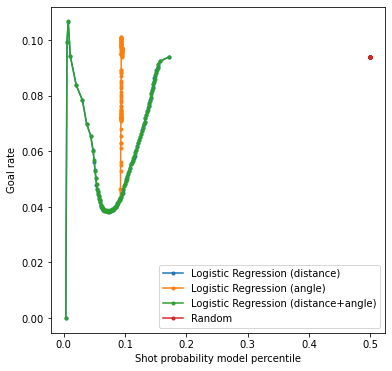

In [261]:
### goal_rate = F(shot probability model percentile) ###
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates


percentiles1, rates1 = compute_goal_rate_per_percentile(lr_probs1, y_val)
percentiles2, rates2 = compute_goal_rate_per_percentile(lr_probs2, y_val)
percentiles3, rates3 = compute_goal_rate_per_percentile(lr_probs3, y_val)
percentiles4, rates4 = compute_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='Logistic Regression (distance)')
plt.plot(percentiles2, rates2, marker='.', label='Logistic Regression (angle)')
plt.plot(percentiles3, rates3, marker='.', label='Logistic Regression (distance+angle)')
plt.plot(percentiles4, rates4, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

plt.savefig('../figures/3-goal_rate_percentile_1.png')

plt.show()

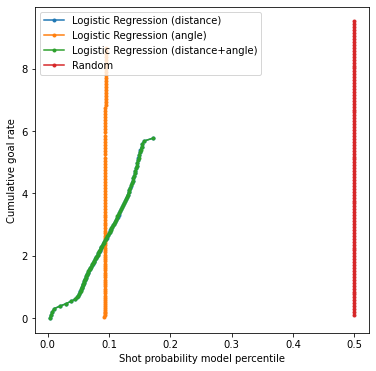

In [262]:
### cumulative portion of goals = F(shot probability model percentile) ###

def compute_cumulative_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []
    cum_rate = 0

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        cum_rate += goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(cum_rate)
    return percentiles, rates


percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(lr_probs1, y_val)
percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(lr_probs2, y_val)
percentiles3, rates3 = compute_cumulative_goal_rate_per_percentile(lr_probs3, y_val)
percentiles4, rates4 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='Logistic Regression (distance)')
plt.plot(percentiles2, rates2, marker='.', label='Logistic Regression (angle)')
plt.plot(percentiles3, rates3, marker='.', label='Logistic Regression (distance+angle)')
plt.plot(percentiles4, rates4, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative goal rate')
plt.legend()

plt.savefig('../figures/3-goal_rate_percentile_2.png')

plt.show()

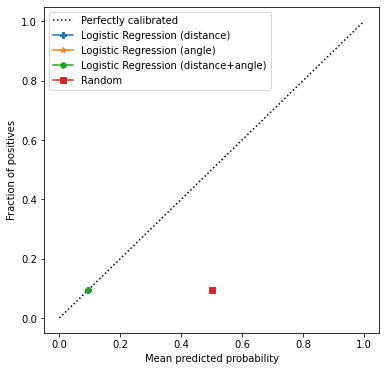

In [263]:
fig, ax = plt.subplots(figsize=(6, 6))


disp1 = CalibrationDisplay.from_estimator(lr_clf1, X_val1, y_val, label='Logistic Regression (distance)', marker="P", ax=ax)
disp2 = CalibrationDisplay.from_estimator(lr_clf2, X_val2, y_val, label='Logistic Regression (angle)', marker="*", ax=ax)
disp3 = CalibrationDisplay.from_estimator(lr_clf3, X_val3, y_val, label='Logistic Regression (distance+angle)', marker="h", ax=ax)
disp4 = CalibrationDisplay.from_estimator(random_clf, X_val3, y_val, label='Random', marker="s", ax=ax)

ax.legend(loc='upper left')

plt.savefig('../figures/3-calibration_diagram.png')

plt.show()

In [264]:
# Do all the 3 logistic regression models always predict 0 as it is the dominating label ?! YES!
np.sum([round(p) for p in lr_probs1]), np.sum([round(p) for p in lr_probs2]), np.sum([round(p) for p in lr_probs3])

(0, 0, 0)